In [1]:
import sys
sys.path.insert(1, "./utils/")
import Stimuli, Morpho


from neuron import h
h.load_file("stdrun.hoc")
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")
from neuron.units import mV, ms

import matplotlib.pyplot as plt
import numpy as np
import queue
import json
import argparse

## Arguments

In [2]:
class args:
    def __init__(
        self, outdir, exp_name, ninputs, duration, 
        num_excitatory_stims, excitatory_interval, excitatory_rev_potential, excitatory_weight, excitatory_tau,
        num_inhibitory_stims, inhibitory_interval, inhibitory_rev_potential, inhibitory_weight, inhibitory_tau,
    ):
        self.outdir = outdir
        self.exp_name = exp_name
        self.ninputs = ninputs
        self.duration = duration
        self.num_excitatory_stims = num_excitatory_stims
        self.excitatory_interval = excitatory_interval
        self.excitatory_rev_potential = excitatory_rev_potential
        self.excitatory_weight = excitatory_weight
        self.excitatory_tau = excitatory_tau
        self.num_inhibitory_stims = num_inhibitory_stims
        self.inhibitory_interval = inhibitory_interval
        self.inhibitory_rev_potential = inhibitory_rev_potential
        self.inhibitory_weight = inhibitory_weight
        self.inhibitory_tau = inhibitory_tau
        
args = args(
    outdir = './data/nInputs_morpho/',
    exp_name = 'test0',
    ninputs = 15,
    duration = 1000,
    num_excitatory_stims = 10,
    excitatory_interval = 5,
    excitatory_rev_potential = 0,
    excitatory_weight = 1,
    excitatory_tau = 2,
    num_inhibitory_stims = 5,
    inhibitory_interval = 15,
    inhibitory_rev_potential = -80,
    inhibitory_weight = .01,
    inhibitory_tau = 6
)

## Setup cell

In [3]:
ca1 = Morpho.Pyramidal()
ca1.load_morphology()

## Generate stimuli

In [4]:
excitatory_stimuli_set = Stimuli.PoissonStimSet(
    args.num_excitatory_stims,
    ca1.all_input_segments,
    args.excitatory_interval,
    args.duration,
    args.excitatory_rev_potential,
    args.excitatory_weight,
    args.excitatory_tau
)

inhibitory_stimuli_set = Stimuli.PoissonStimSet(
    args.num_inhibitory_stims,
    ca1.all_input_segments,
    args.inhibitory_interval,
    args.duration,
    args.inhibitory_rev_potential,
    args.inhibitory_weight,
    args.inhibitory_tau
)

(0.0, 1000.0)

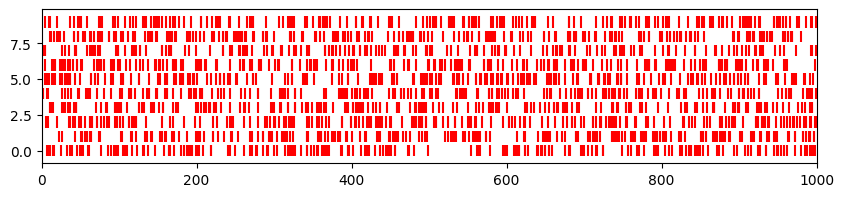

In [5]:
plt.figure(figsize=(10,2))
for i, stimuli in enumerate(excitatory_stimuli_set.stimuli):
    plt.vlines(stimuli.stim_times, i-.4, i+.4, color='red')
    
plt.xlim(0, args.duration)

(0.0, 1000.0)

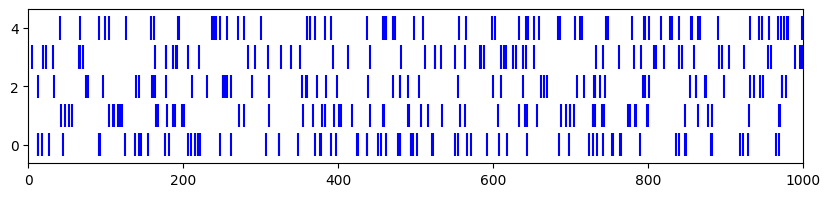

In [6]:
plt.figure(figsize=(10,2))
for i, stimuli in enumerate(inhibitory_stimuli_set.stimuli):
    plt.vlines(stimuli.stim_times, i-.4, i+.4, color='blue')
    
plt.xlim(0, args.duration)

## Connect stimuli to cell

In [7]:
for stimuli in excitatory_stimuli_set.stimuli:
    ca1.connect_input(stimuli, ca1.all_input_segments[stimuli.stim_id])
    
for stimuli in inhibitory_stimuli_set.stimuli:
    ca1.connect_input(stimuli, ca1.all_input_segments[stimuli.stim_id])

In [29]:
h.finitialize(-65)
h.continuerun(1000)

0.0

In [30]:
list(ca1.spike_times)

[]

In [28]:
ca1.netcons

[NetCon[1],
 NetCon[2],
 NetCon[3],
 NetCon[4],
 NetCon[5],
 NetCon[6],
 NetCon[7],
 NetCon[8],
 NetCon[9],
 NetCon[10],
 NetCon[11],
 NetCon[12],
 NetCon[13],
 NetCon[14],
 NetCon[15],
 NetCon[16],
 NetCon[17],
 NetCon[18],
 NetCon[19],
 NetCon[20],
 NetCon[21],
 NetCon[22],
 NetCon[23],
 NetCon[24],
 NetCon[25],
 NetCon[26],
 NetCon[27],
 NetCon[28],
 NetCon[29],
 NetCon[30],
 NetCon[31],
 NetCon[32],
 NetCon[33],
 NetCon[34],
 NetCon[35],
 NetCon[36],
 NetCon[37],
 NetCon[38],
 NetCon[39],
 NetCon[40],
 NetCon[41],
 NetCon[42],
 NetCon[43],
 NetCon[44],
 NetCon[45],
 NetCon[46],
 NetCon[47],
 NetCon[48],
 NetCon[49],
 NetCon[50],
 NetCon[51],
 NetCon[52],
 NetCon[53],
 NetCon[54],
 NetCon[55],
 NetCon[56],
 NetCon[57],
 NetCon[58],
 NetCon[59],
 NetCon[60],
 NetCon[61],
 NetCon[62],
 NetCon[63],
 NetCon[64],
 NetCon[65],
 NetCon[66],
 NetCon[67],
 NetCon[68],
 NetCon[69],
 NetCon[70],
 NetCon[71],
 NetCon[72],
 NetCon[73],
 NetCon[74],
 NetCon[75],
 NetCon[76],
 NetCon[77],
 NetCon[

In [31]:
def event_sim(events):
    '''
    # used for simulating a morpho cell, detatched from other simulations, for n inputs
    :param events:
    :return:
    '''
    pyr = Pyramidal()

    # generate necessary synapses
    syns = {}
    for event in events:
        syns[event.seg_ind] = h.ExpSyn(pyr.all_input_segments[event.seg_ind])
        syns[event.seg_ind].tau = event.tau
        syns[event.seg_ind].e = event.rev_potential

    # create net connections for each stimulus
    min_event_time = min([event.t for event in events])
    max_event_time = max([event.t for event in events])

    netstims = [h.NetStim() for event in events]
    for netstim, event in zip(netstims, events):
        netstim.number = 1
        netstim.start = event.t - min_event_time
        netcon = h.NetCon(netstim, syns[event.seg_ind])
        netcon.weight[0] = event.weight
        netcon.delay = 0 * ms
        pyr.netcons.append(netcon)

    # run simulation
    h.finitialize(-65)
    h.continuerun(max_event_time - min_event_time + 20)
    nsts = [spike + min_event_time for spike in list(pyr.spike_times)]
    nsts = [spike for spike in nsts if spike > max_event_time]
    if len(nsts) > 0:
        return nsts[0]
    else:
        return None

In [ ]:
event_sim()